In [1]:
from pandas import read_csv, to_datetime, DataFrame, concat
import matplotlib.pyplot as plt
from numpy import sqrt, exp, log,zeros, nan
from scipy.stats import probplot
from pingouin import multivariate_normality 

from statsmodels.tsa.vector_ar.var_model import VAR,VARResults
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,root_mean_squared_error

## Les fonctions qui seront utilisées 

In [2]:
def r2_ajuste(r2,n,p):

    return  1 - (  ((1 - r2) * (n - 1)) / (n - p - 1)  )

In [3]:
def invert_transformation(df_original, df_forecast, transfo):
    """
    
    Revert back the differencing to get the forecast to original scale.
    
    """
    df_train = df_original.copy()
    df_fc = df_forecast.copy()
    df_fcout = df_forecast.copy()
    columns = df_forecast.columns
    
    for col in columns:
        # Retirer le logarithme si nécessaire
        if transfo.loc[ 'loga'] == 1:
            df_fcout[col] = exp(df_fcout[col])
        
        # Récupérer l'ordre de différenciation
        diff_order = transfo.loc[ 'ordreP']
        
        # Inverser la différenciation uniquement si l'ordre est 3
        if diff_order > 0 :
            for i in range(diff_order):
                df_fcout[col].iloc[i] = df_train[col].iloc[i]
            for j in range(diff_order, len(df_train[col])):
                df_fcout.loc[j,col] = df_fcout.loc[j - diff_order,col] + df_fc.loc[j,col]
            
        elif diff_order == 0:
            continue
        else:
            print(f"Vous n'avez pas fourni un bon ordre de différentiation. il est de {diff_order}")

    return df_fcout

## Doit on différentier toutes les variables ? 
## A quel niveau de la différentiation doit on s'arreter ?
## est il mieux de rajouter un log pour avoir une diff < 2 ??
## analyse de la causalité dans les clusters ???

## Nous avons 5 familles cibles DTC, DT5, DTC_BTY, DEL, DNE 

## import des dataframes d'informations

In [4]:
dfOrig = read_csv("Product families over time.csv")
#df2 = dfTime.set_index('Product Family').T
#df2.index = to_datetime(df2.index)
dfOrig = dfOrig.set_index('Product Family').T
#dfOrig.head(4)

In [5]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=12, verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    # Remove columns with constant values
    data = data.loc[:, (data != data.iloc[0]).any()]
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in df.columns:
        for r in df.index:
            if r != c:
                try:
                    test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
                    p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
                    if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                    min_p_value = min(p_values)
                    df.loc[r, c] = min_p_value
                except Exception as e:
                    df.loc[r, c] = np.nan
                    if verbose: print(f'Failed to test Granger causality between {r} and {c}: {e}')
    
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# Exemple d'utilisation
maxlag = 12

In [6]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = DataFrame(zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
"""
maxlag = 12
df = dfOrig
grangers_causation_matrix(df, variables = df.columns)
"""

'\nmaxlag = 12\ndf = dfOrig\ngrangers_causation_matrix(df, variables = df.columns)\n'

In [7]:
def invert_transformations(df_differentiated, df_transformations, df_original):
    df_reverted = pd.DataFrame(index=df_original.index)

    for index, row in df_transformations.iterrows():
        family = row['family']
        orderP = int(row['ordreP'])
        loga = int(row['loga'])
        petit_truc = row.get('Petit_truc', 0)

        inverted_series = df_differentiated[family].copy()
        revertSerie = pd.Series(index = df_original.index)
        revertSerie.update(df_differentiated[family].copy())
      
        if orderP == 2:
            
            
            # Retour à l'ordre 1 
            diff_ordre_1 = df_original[family].diff().dropna()
            first_value_ordre_1 = diff_ordre_1.iloc[0]
            vectBuff2 = (first_value_ordre_1 + np.cumsum(inverted_series))
            inverted_series_ordre_1 = np.concatenate(([first_value_ordre_1], vectBuff2))
            
            # Puis retour à l'ordre 0
            
            first_value_orig = df_original[family].iloc[0]
            if loga == 0:
                inverted_series = np.concatenate(([first_value_orig], (first_value_orig + np.cumsum(inverted_series_ordre_1))))
            if loga == 1:
                invbuff = np.concatenate(([first_value_orig], (first_value_orig + np.cumsum(inverted_series_ordre_1))))
                inverted_series = np.exp(invbuff) - petit_truc
            #inverted_series = inverted_series[:len(df_original[family])]

        elif orderP == 1:
            revertSerie.iloc[1] = df_original[family].iloc[1] - df_original[family].iloc[0]
            
            vectBuff = ( np.cumsum(revertSerie.dropna()) + df_original[family].iloc[0] )
            
            #inverted_series = np.concatenate( ( [df_original[family].iloc[0]] , vectBuff  ) )
            if loga == 0:
                inverted_series = np.concatenate( ( [df_original[family].iloc[0]] , vectBuff  ) )
            if loga == 1:
                invbuff = np.concatenate( ( [df_original[family].iloc[0]] , vectBuff  ) )
                inverted_series = np.exp(invbuff) - petit_truc
            
        elif orderP == 0:    
            inverted_series = df_original[family]

        df_reverted[family] = inverted_series

    return df_reverted

## jeu de données différentié

In [8]:
df_diff = read_csv("series_differenciees.csv")
df_diff = df_diff.set_index('Unnamed: 0')
#df_diff

In [9]:
df_clust = read_csv("clustered_product_families.csv")

In [10]:
df_list_diffs = read_csv("transformations_appliquees.csv")

dictTransformations = df_list_diffs.set_index('family')


In [11]:
maxlags_per_cluster = {
    1: 2,  # Cluster 1 avec maxlags = 4
    2: 4,  # Cluster 2 avec maxlags = 3
    3: 4,  # Cluster 3 avec maxlags = 2
}

## division pour avoir le jeu d'entrainement et le jeu de test 

In [12]:
# Définir le point de division
n = 3
# Diviser les données

df_train = df_diff.iloc[:-n]
df_test = df_diff.iloc[-n:]

# Vérifier les tailles des ensembles d'entraînement et de test
print('Training set:', len(df_train))
print('Test set:', len(df_test))

Training set: 48
Test set: 3


### Choix du maxlag un peu au piff

## Choix du p

In [13]:

# import numpy as np
# import pandas as pd
# from statsmodels.tsa.api import VAR
# from sklearn.metrics import mean_squared_error

# def rolling_window_validation(cluster_data, maxlags, test_size=10):
#     """
#     Effectue une validation croisée en utilisant une fenêtre roulante pour choisir le meilleur lag (p) pour un modèle VAR.
    
#     Paramètres :
#     - cluster_data : DataFrame contenant les séries temporelles pour un cluster donné.
#     - maxlags : Nombre maximum de lags à tester.
#     - test_size : Nombre d'observations dans l'ensemble de validation.
    
#     Retourne :
#     - errors : Un dictionnaire avec les erreurs de prévision pour chaque lag testé.
#     """
#     errors = {}

#     # Diviser les données en ensembles d'entraînement et de test
#     train_data = cluster_data[:-test_size]
#     test_data = cluster_data[-test_size:]

#     for p in range(1, maxlags + 1):
#         model = VAR(train_data)
#         model_fitted = model.fit(p)

#         # Prévoir la série temporelle sur l'ensemble de test
#         predictions = model_fitted.forecast(train_data.values[-p:], steps=test_size)

#         # Calculer l'erreur quadratique moyenne (MSE)
#         mse = mean_squared_error(test_data.values, predictions)
#         errors[p] = mse

#     return errors

# # Boucle sur les clusters
# for cluster in df_clust['clusters'].unique():
#     # Sélectionner les familles de produits appartenant à ce cluster
#     if cluster == 0:
#         break
#     families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
#     print("Cluster Numéro {0}".format(cluster))
    
#     # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
#     cluster_data = df_train[families_in_cluster].dropna()
    
#     # Validation croisée pour déterminer le meilleur lag
#     maxlags = 7  # Nombre maximum de lags à tester
#     test_size = 10  # Taille de l'ensemble de validation
#     errors = rolling_window_validation(cluster_data, maxlags=maxlags, test_size=test_size)
    
#     # Afficher les erreurs pour chaque lag
#     for p, mse in errors.items():
#         print(f'Lag {p}: MSE = {mse}')
    
#     # Trouver le lag avec la plus faible erreur MSE
#     best_p = min(errors, key=errors.get)
#     print(f'Le meilleur lag pour le cluster {cluster} est {best_p} avec une MSE de {errors[best_p]}')
#     print("-------------------------------------------------------")


In [ ]:
#from unittest import result

maxlags_per_cluster = {
    0: 1,  # Cluster 1 avec maxlags = 4
    1: 7,  # Cluster 2 avec maxlags = 3
    2: 8,  # Cluster 3 avec maxlags = 2
}
orderVar = dict()
orderP = dict()
for cluster in df_clust['clusters'].unique():
    # Sélectionner les familles de produits appartenant à ce cluster
    #if cluster == 0:
    #    break
    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    print("Cluster Numéro {0}".format(cluster))
    # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
    cluster_data = df_train[families_in_cluster].dropna()
    
    # Ajuster le modèle VAR
    model = VAR(cluster_data)
    mlg = maxlags_per_cluster[cluster]
    # Choisir l'ordre optimal p pour le modèle VAR
    order_selection = model.select_order(maxlags=mlg)
    #best_p = order_selection.aic  # Utilisez aic, bic, fpe ou hqic en fonction de votre préférence
    print(order_selection.summary())
    """
    # Ajuster le modèle VAR avec le meilleur ordre p
    results = model.fit(best_p)
    print('order of var for the cluster {0} is {1}'.format(cluster,results.k_ar))
    orderVar[cluster] = results.k_ar
    orderP[cluster] = best_p
    """
  

# Tests statistiques 

## Affichage des résidus

Cluster Numéro 1


d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


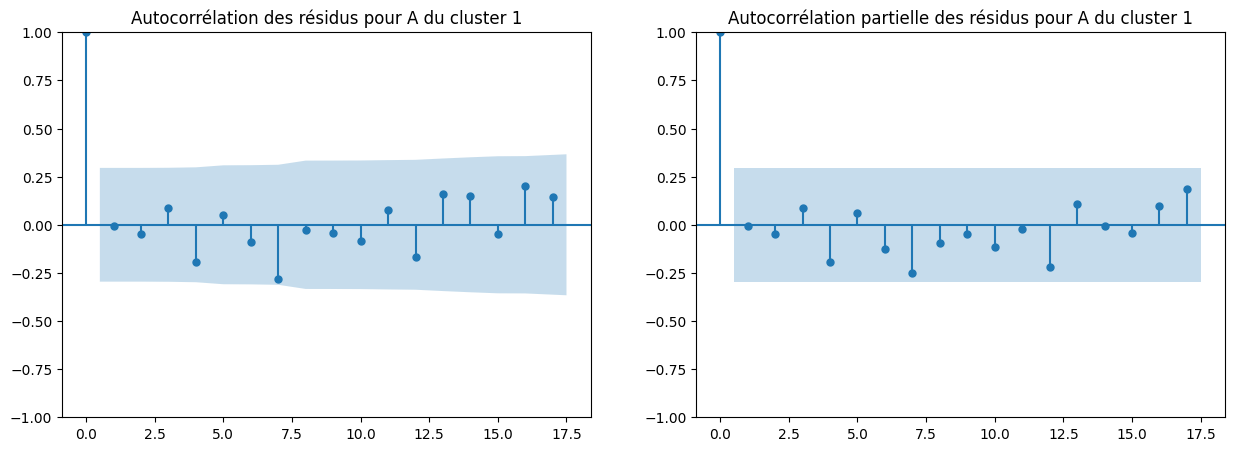

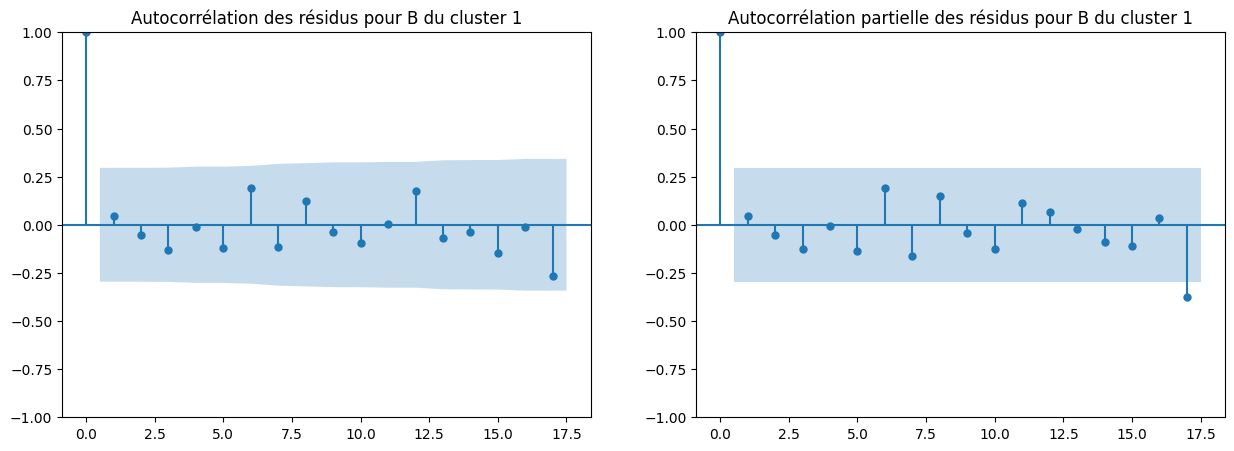

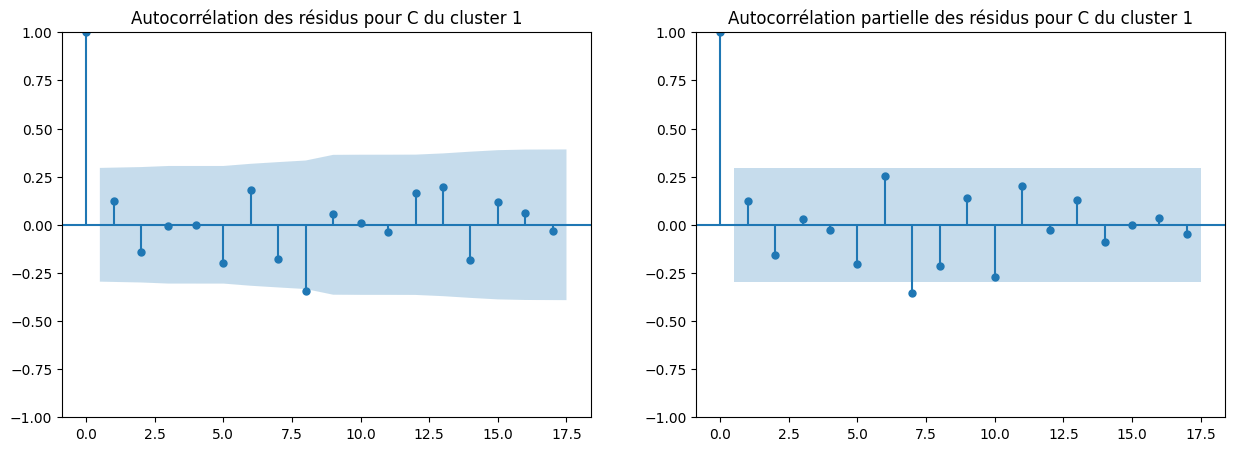

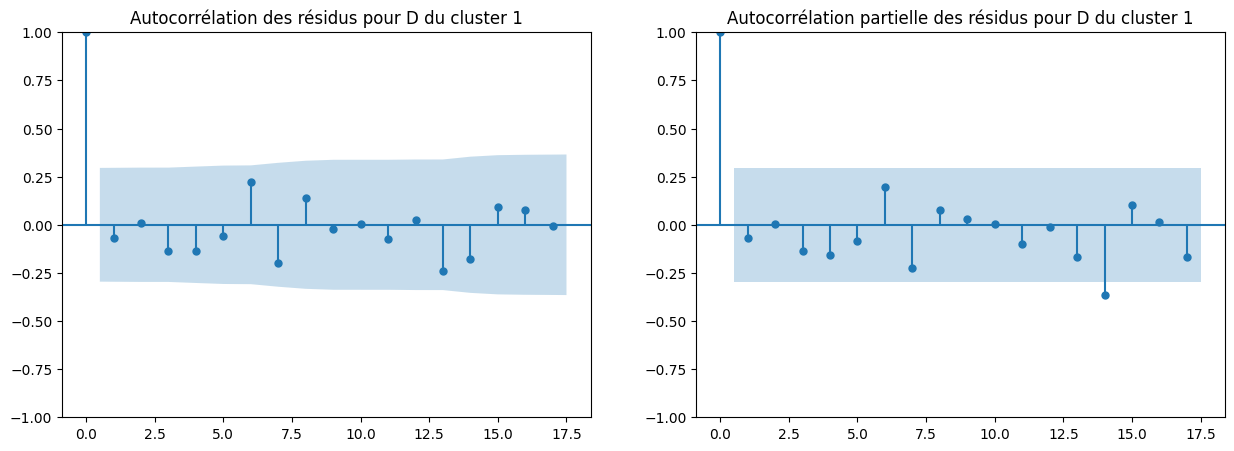

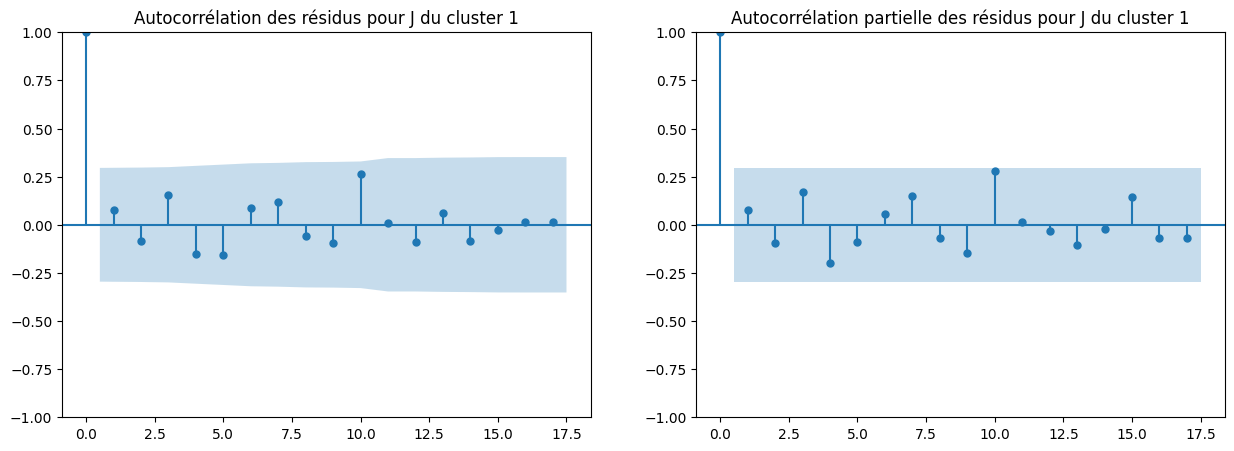

Cluster Numéro 2


d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


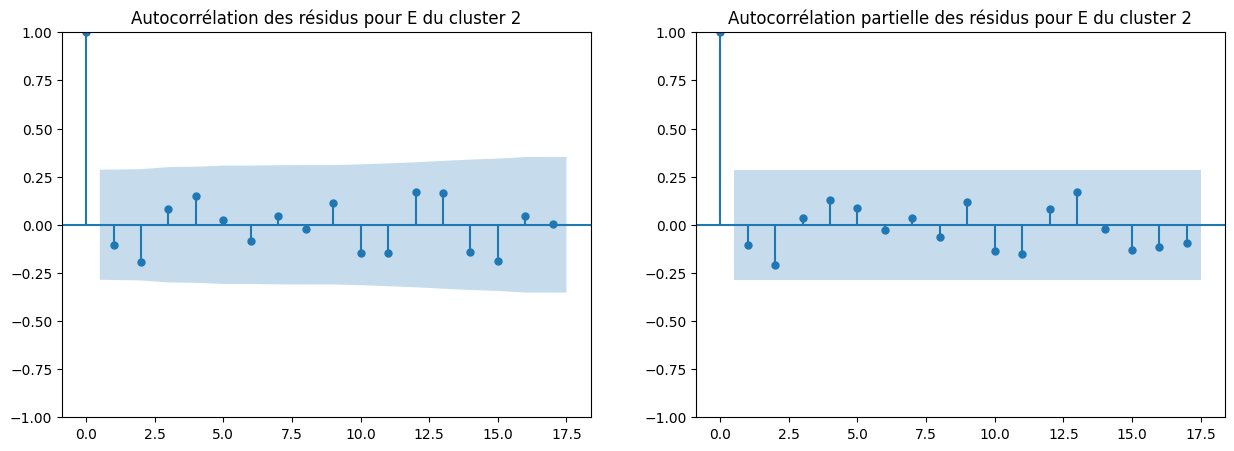

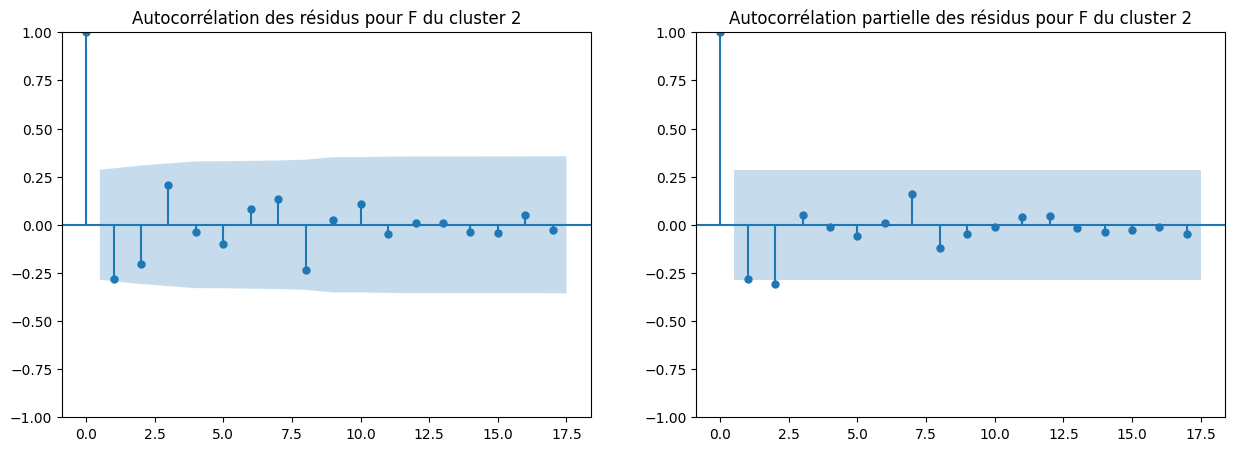

Cluster Numéro 0


d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\regression\linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)


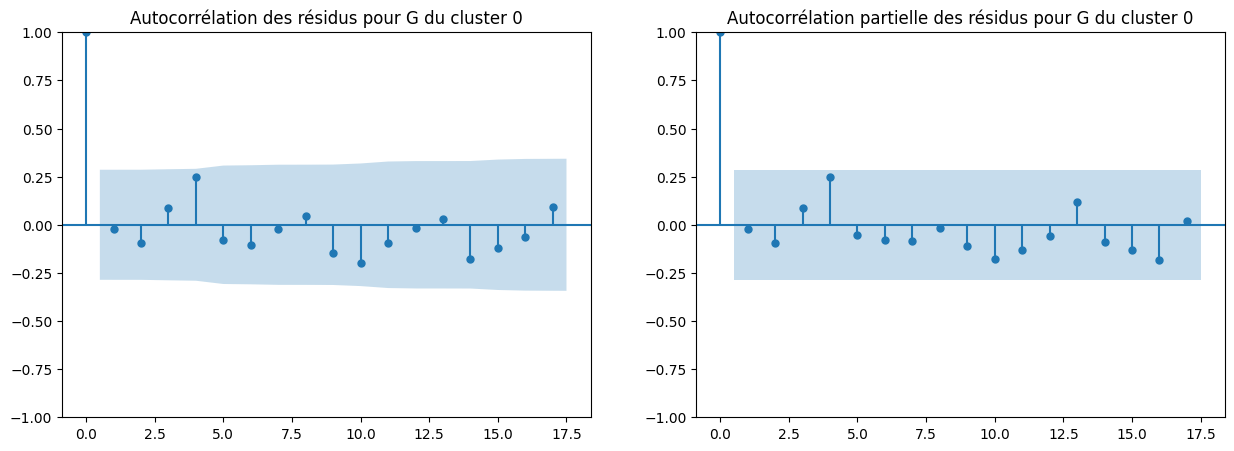

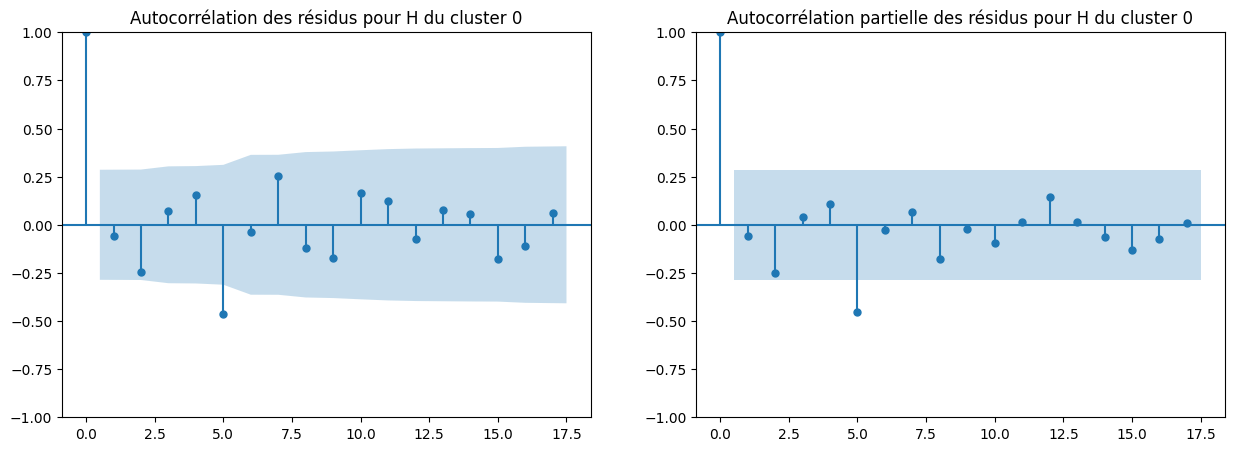

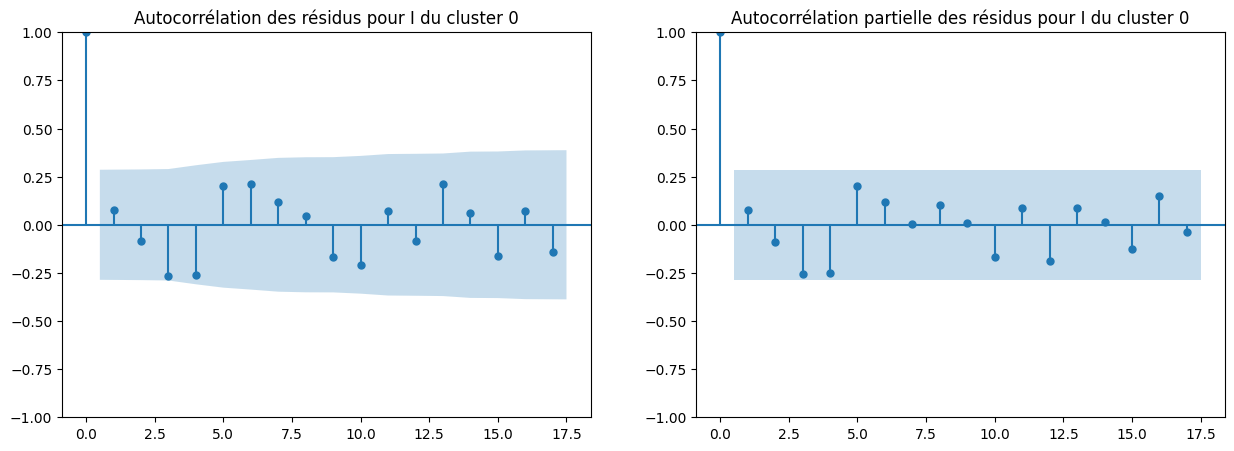

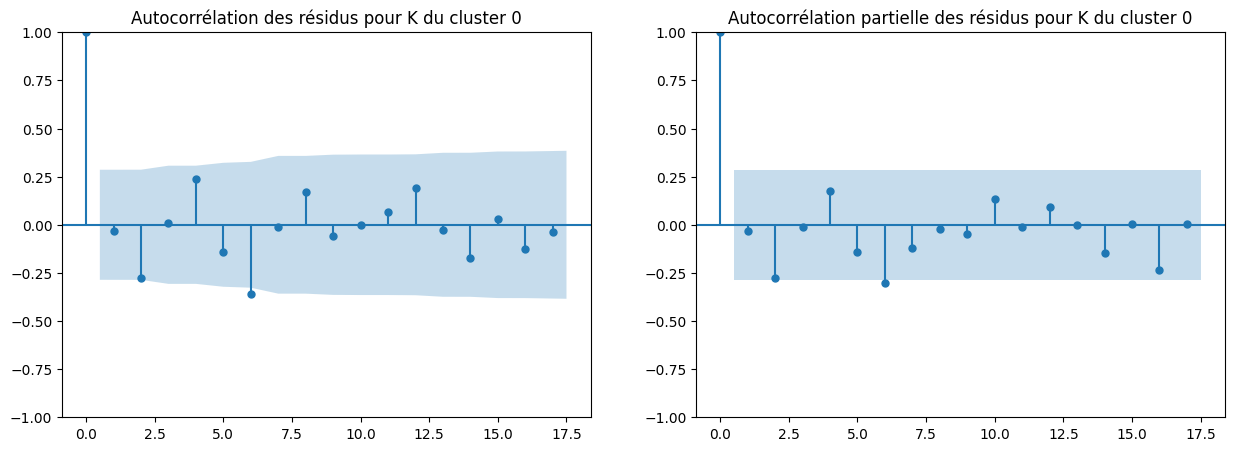

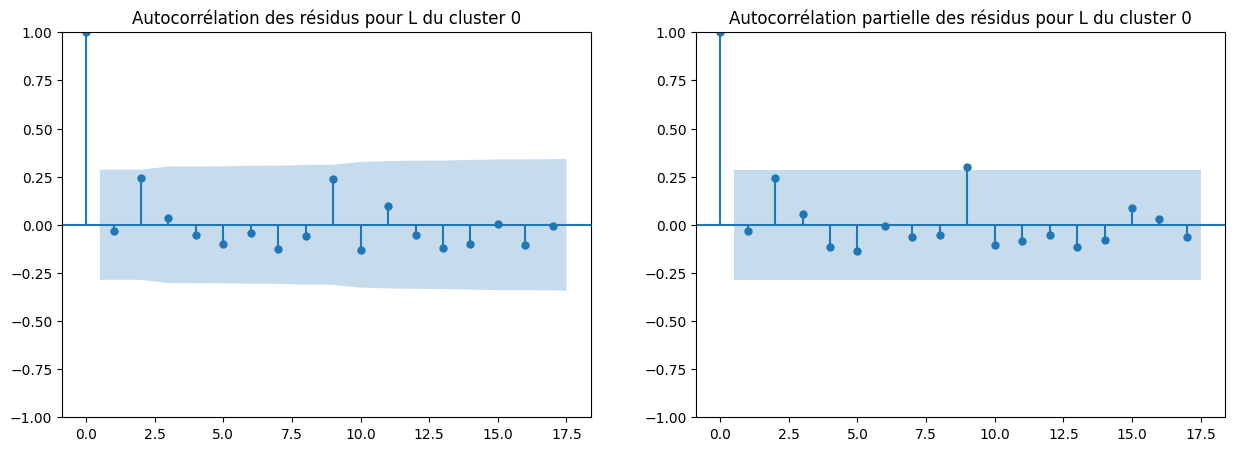

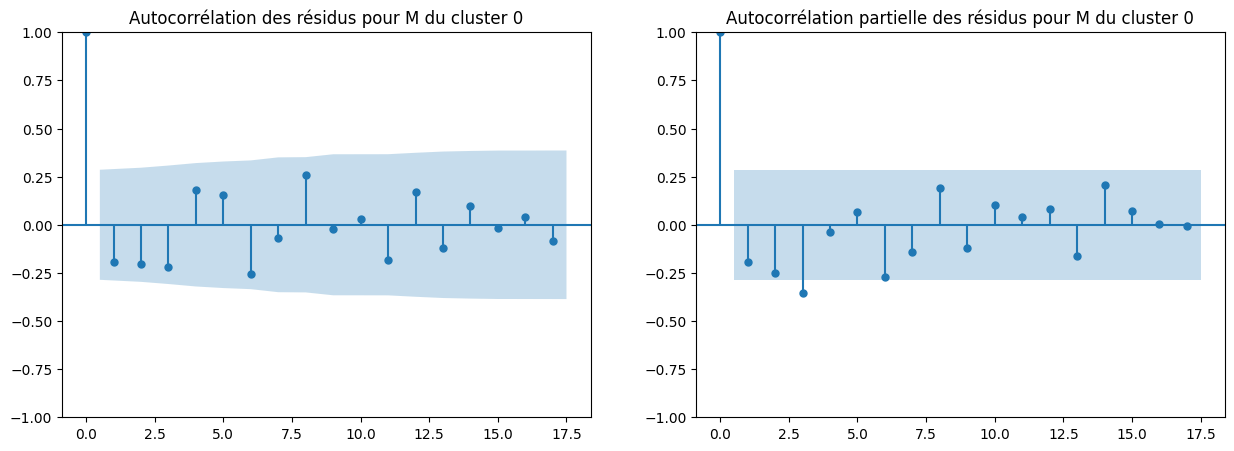

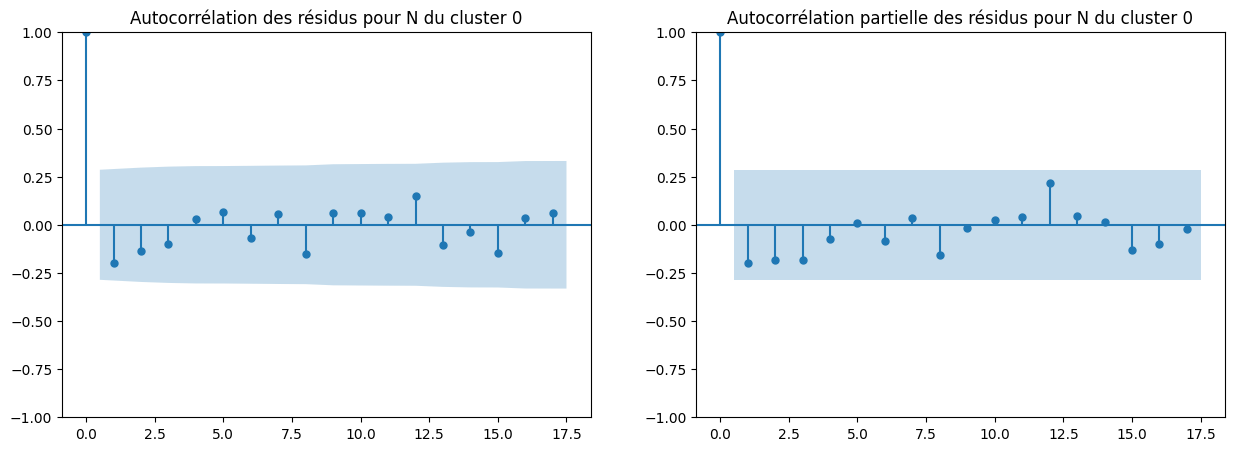

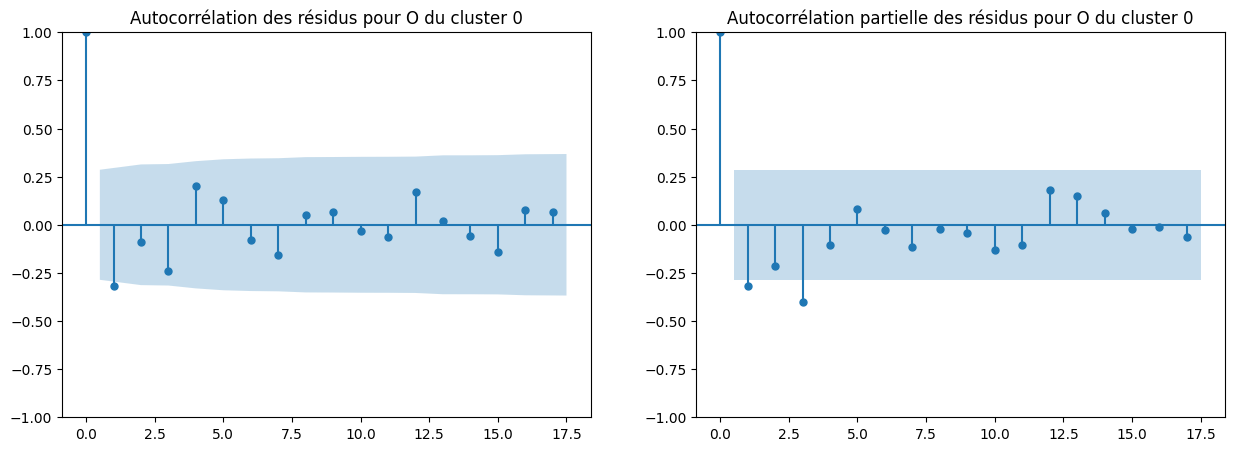

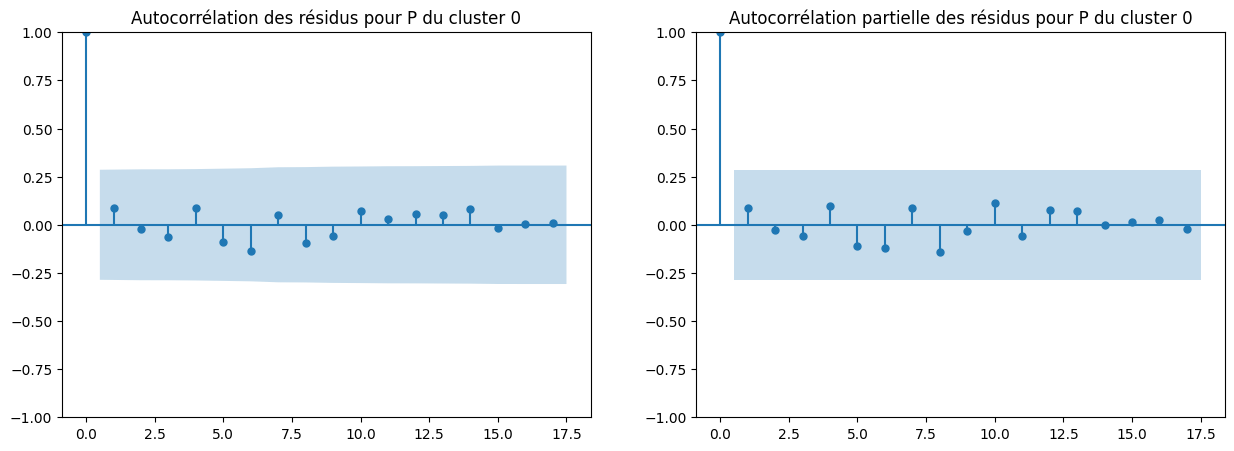

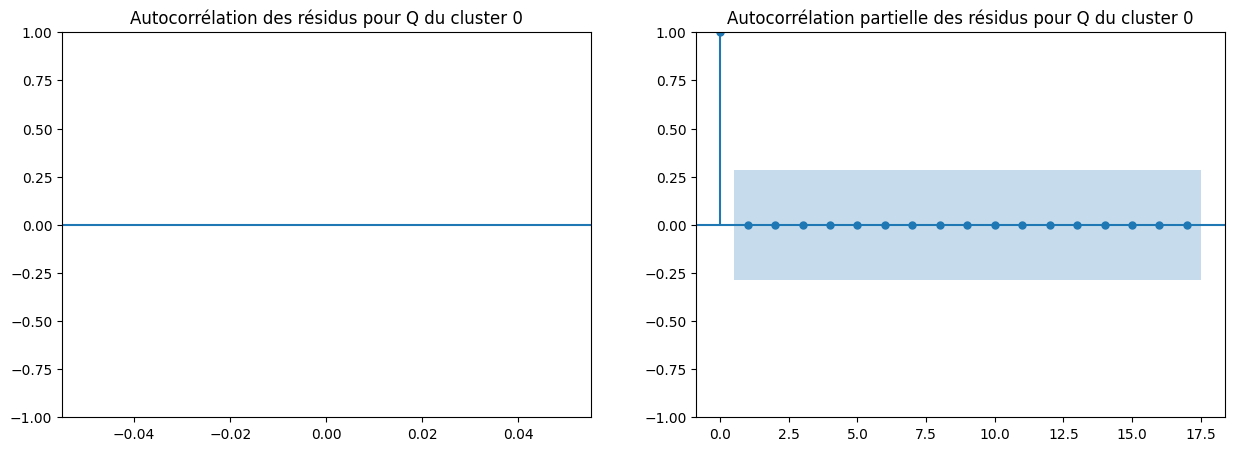

In [15]:
ordervarclust = { 2: 1,  1: 4, 0:1}
for cluster in df_clust['clusters'].unique():

    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
    cluster_data = df_train[families_in_cluster].dropna()
   
    print("Cluster Numéro {0}".format(cluster))
    model = VAR(cluster_data)
    order = ordervarclust[cluster]
    results = model.fit(order)
    residuals = results.resid
    for col in residuals.columns:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
        plot_acf(residuals[col], ax=axes[0])
        axes[0].set_title(f'Autocorrélation des résidus pour {col} du cluster {cluster}')
    
        plot_pacf(residuals[col], ax=axes[1])
        axes[1].set_title(f'Autocorrélation partielle des résidus pour {col} du cluster {cluster}')
    plt.show()

## les résidus du cluster 1 et 2 semblent être des bruits blancs

## Test de jarque_bera : test de normalité des erreurs 

## lhypothèse H0 est stipule que les données suivent une loi normale 
## si la p-value est < à 0.05, on rejète l'hypothèse nulle

In [16]:
ordervarclust = { 2: 1,  1: 4, 0:1}
for cluster in df_clust['clusters'].unique():

    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
    cluster_data = df_train[families_in_cluster].dropna()
   
    print("Cluster Numéro {0}".format(cluster))
    model = VAR(cluster_data)
    order = ordervarclust[cluster]
    results = model.fit(order)
    residuals = results.resid
    for col in residuals.columns:
        print(f"Résidus pour {col}:")
        jb_test = jarque_bera(residuals[col])
        print(f"Test de Jarque-Bera: statistic={jb_test[0]}, p-value={jb_test[1]}")

Cluster Numéro 1
Résidus pour A:
Test de Jarque-Bera: statistic=2.5462719897898967, p-value=0.279952314717995
Résidus pour B:
Test de Jarque-Bera: statistic=0.8311808110463289, p-value=0.6599505272237124
Résidus pour C:
Test de Jarque-Bera: statistic=0.5042566722467591, p-value=0.7771449958927442
Résidus pour D:
Test de Jarque-Bera: statistic=3.584797929563432, p-value=0.16656011814667335
Résidus pour J:
Test de Jarque-Bera: statistic=0.7465545060658612, p-value=0.688474324785618
Cluster Numéro 2
Résidus pour E:
Test de Jarque-Bera: statistic=3.0185441106604096, p-value=0.2210708467450222
Résidus pour F:
Test de Jarque-Bera: statistic=2.485704157555375, p-value=0.28856004721106476
Cluster Numéro 0
Résidus pour G:
Test de Jarque-Bera: statistic=6.445261819598327, p-value=0.0398500782633548
Résidus pour H:
Test de Jarque-Bera: statistic=1.9453808983104592, p-value=0.37806450523360996
Résidus pour I:
Test de Jarque-Bera: statistic=28.719861126617587, p-value=5.801781860216559e-07
Résidus 

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## test de normalité de statsmodels

In [17]:
ordervarclust = { 2: 1,  1: 4, 0:1}
for cluster in df_clust['clusters'].unique():

    if cluster == 0 :
        break
    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
    cluster_data = df_train[families_in_cluster].dropna()
   
    print("Cluster Numéro {0}".format(cluster))
    model = VAR(cluster_data)
    order = ordervarclust[cluster]
    results = model.fit(order)
    print(results.test_normality())
    print(results.test_whiteness())

Cluster Numéro 1
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: fail to reject at 5% significance level. Test statistic: 7.445, critical value: 18.307>, p-value: 0.683>
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 187.516, critical value: 179.581>, p-value: 0.020>
Cluster Numéro 2
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: fail to reject at 5% significance level. Test statistic: 3.021, critical value: 9.488>, p-value: 0.554>
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: fail to reject at 5% significance level. Test statistic: 45.325, critical value: 50.998>, p-value: 0.137>


d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## test de normalité multivariée

In [18]:
ordervarclust = { 2: 1,  1: 4, 0:1}
for cluster in df_clust['clusters'].unique():

    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
    cluster_data = df_train[families_in_cluster].dropna()
   
    print("Cluster Numéro {0}".format(cluster))
    model = VAR(cluster_data)
    order = ordervarclust[cluster]
    results = model.fit(order)
    residuals = results.resid

    data = residuals
    print(multivariate_normality(data, alpha=.05) )



Cluster Numéro 1
HZResults(hz=0.7705103464262439, pval=0.7524095652202045, normal=True)
Cluster Numéro 2
HZResults(hz=0.8255751434897904, pval=0.06552729606587906, normal=True)
Cluster Numéro 0
HZResults(hz=188, pval=0.0, normal=False)


d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Test de acorr_ljungbox : autocorrelation des résidus 

## lhypothèse H0 stipule qu'il n'y a pas d'autocorrlation entre les erreurs d'ordre 1 à p
## si la p-value est < à 0.05, on rejète l'hypothèse nulle

In [19]:
ordervarclust = { 2: 1,  1: 4, 0:1}
maxlags_per_cluster = {
    0: 7,  # Cluster 1 avec maxlags = 4
    1: 7,  # Cluster 2 avec maxlags = 3
    2: 8,  # Cluster 3 avec maxlags = 2
}
for cluster in df_clust['clusters'].unique():

    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
    cluster_data = df_train[families_in_cluster].dropna()
    mlg = maxlags_per_cluster[cluster]
    print("Cluster Numéro {0}".format(cluster))
    model = VAR(cluster_data)
    order = ordervarclust[cluster]
    results = model.fit(order)
    residuals = results.resid
    results_list = list()
    #results_df = DataFrame(columns=['Variable', 'Lag', 'LB Statistic', 'LB P-value'])

    # Effectuer le test de Ljung-Box pour des décalages de 1 à maxlag
    for col in residuals.columns:
        for lag in range(1, mlg+1):
            lb_test = acorr_ljungbox(residuals[col], lags=[lag], return_df=True)
            results_list.append({
                'Variable': col,
                'Lag': lag,
                'LB Statistic': lb_test['lb_stat'].values[0],
                'LB P-value': lb_test['lb_pvalue'].values[0]
            })
    results_df = DataFrame(results_list)
    print(results_df)

Cluster Numéro 1
   Variable  Lag  LB Statistic  LB P-value
0         A    1      0.002068    0.963731
1         A    2      0.110265    0.946360
2         A    3      0.493613    0.920292
3         A    4      2.338439    0.673780
4         A    5      2.466367    0.781552
5         A    6      2.889169    0.822623
6         A    7      7.245241    0.403800
7         B    1      0.087208    0.767757
8         B    2      0.212875    0.899031
9         B    3      1.061739    0.786318
10        B    4      1.071839    0.898714
11        B    5      1.828351    0.872349
12        B    6      3.771573    0.707556
13        B    7      4.507822    0.719775
14        C    1      0.690249    0.406080
15        C    2      1.643468    0.439669
16        C    3      1.646684    0.648852
17        C    4      1.646690    0.800377
18        C    5      3.738026    0.587715
19        C    6      5.463310    0.485902
20        C    7      7.176138    0.410774
21        D    1      0.227993    0.6

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


## auto correlation au niveau des lags 

Cluster Numéro 1


d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Cluster Numéro 2


d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


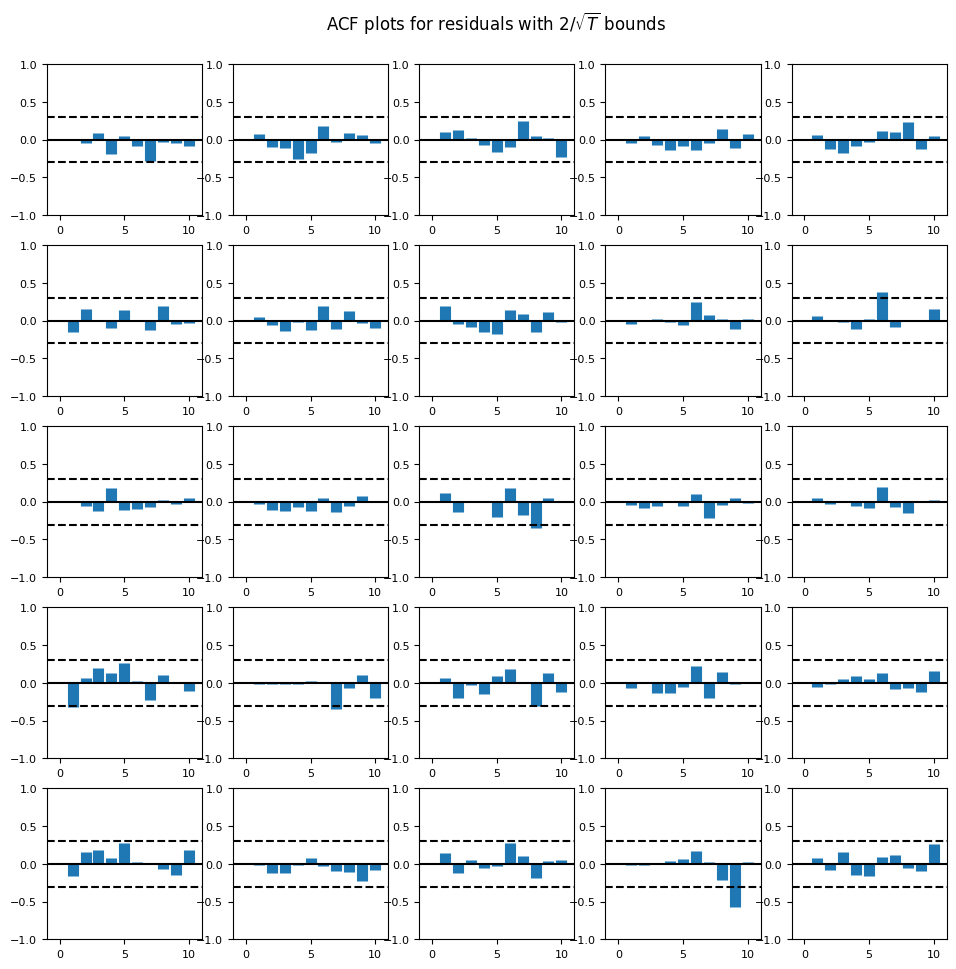

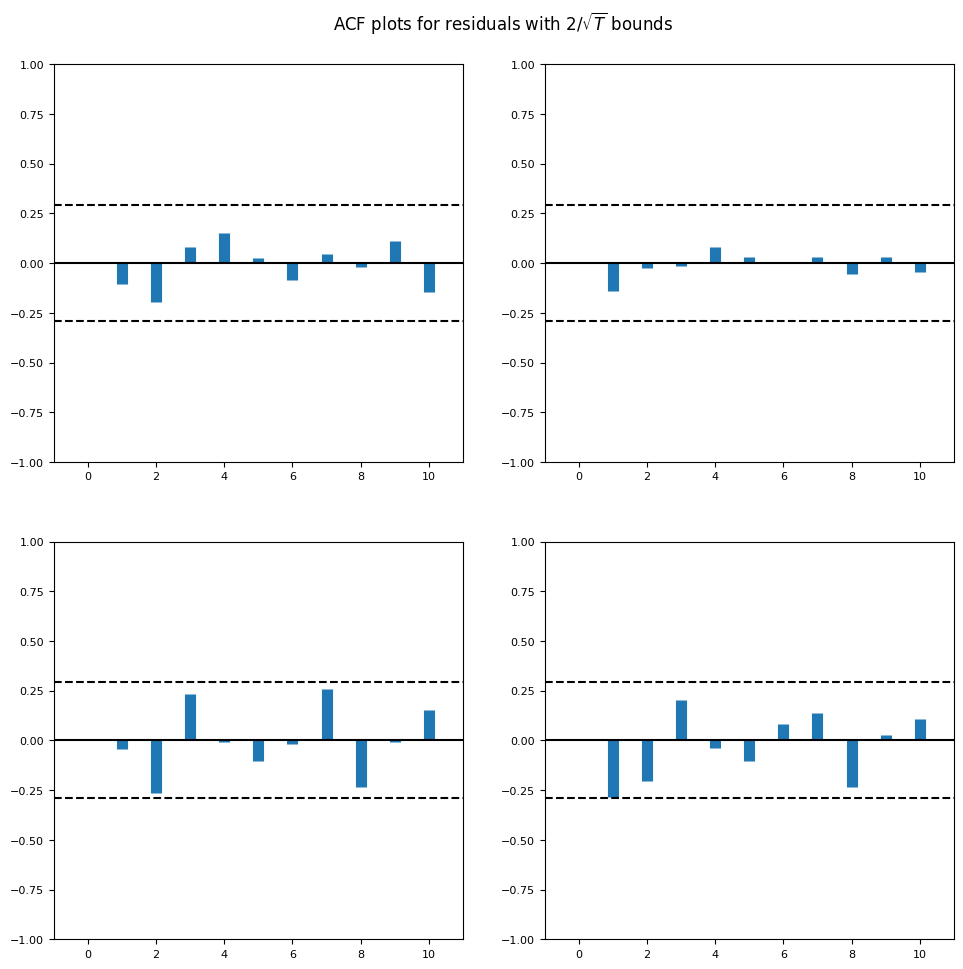

In [20]:
ordervarclust = { 2: 1,  1: 4, 0:1}
maxlags_per_cluster = {
    1: 2,  # Cluster 1 avec maxlags = 4
    2: 4,  # Cluster 2 avec maxlags = 3
    3: 4,  # Cluster 3 avec maxlags = 2
}
for cluster in df_clust['clusters'].unique():

    if cluster == 0:
        break
    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
    cluster_data = df_train[families_in_cluster].dropna()
    mlg = maxlags_per_cluster[cluster]
    print("Cluster Numéro {0}".format(cluster))
    model = VAR(cluster_data)
    order = ordervarclust[cluster]
    results = model.fit(order)
    results.plot_acorr()

## Summary du modèle 

In [21]:
ordervarclust = { 2: 1,  1: 4, 0:1}
maxlags_per_cluster = {
    1: 2,  # Cluster 1 avec maxlags = 4
    2: 4,  # Cluster 2 avec maxlags = 3
    3: 4,  # Cluster 3 avec maxlags = 2
}
for cluster in df_clust['clusters'].unique():

    if cluster == 0:
        break
    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
    cluster_data = df_train[families_in_cluster].dropna()
    mlg = maxlags_per_cluster[cluster]
    print("Cluster Numéro {0}".format(cluster))
    model = VAR(cluster_data)
    order = ordervarclust[cluster]
    results = model.fit(order)
    print(results.summary())

## grande correlation entre F_DPY et F_DIV_MCTP dans le cluster 2

Cluster Numéro 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 23, Aug, 2024
Time:                     17:14:02
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    123.214
Nobs:                     44.0000    HQIC:                   120.536
Log likelihood:          -2824.21    FPE:                7.00418e+51
AIC:                      118.957    Det(Omega_mle):     9.95529e+50
--------------------------------------------------------------------
Results for equation A
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const    134404.546859    115454.094267            1.164           0.244
L1.A         -1.817863         0.117593          -15.459           0.000
L1.B         -0.255913         0.191952           -1.333           0.182
L1.C  

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Forecast Error Variance Decomposition (FEVD)


In [22]:
ordervarclust = { 2: 1,  1: 4, 0:1}
maxlags_per_cluster = {
    1: 2,  # Cluster 1 avec maxlags = 4
    2: 4,  # Cluster 2 avec maxlags = 3
    3: 4,  # Cluster 3 avec maxlags = 2
}
for cluster in df_clust['clusters'].unique():

    if cluster == 0:
        break
    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
    cluster_data = df_train[families_in_cluster].dropna()
    mlg = maxlags_per_cluster[cluster]
    print("Cluster Numéro {0}".format(cluster))
    model = VAR(cluster_data)
    order = ordervarclust[cluster]
    results = model.fit(order)
    fevd = results.fevd(10)
    print(fevd.summary())

Cluster Numéro 1
FEVD for A
            A         B         C         D         J
0    1.000000  0.000000  0.000000  0.000000  0.000000
1    0.961079  0.006881  0.004761  0.027033  0.000248
2    0.963962  0.005790  0.007659  0.018699  0.003890
3    0.815701  0.024104  0.078413  0.051445  0.030338
4    0.750303  0.022301  0.121437  0.060011  0.045948
5    0.715101  0.063405  0.115602  0.060282  0.045609
6    0.696561  0.091661  0.107593  0.061701  0.042485
7    0.730880  0.080897  0.097149  0.054065  0.037008
8    0.741461  0.070379  0.084911  0.064998  0.038252
9    0.713275  0.071980  0.084892  0.081145  0.048708

FEVD for B
            A         B         C         D         J
0    0.132240  0.867760  0.000000  0.000000  0.000000
1    0.134506  0.777869  0.005789  0.024193  0.057644
2    0.138789  0.747518  0.007096  0.037999  0.068598
3    0.128204  0.690961  0.026962  0.035192  0.118682
4    0.111892  0.696458  0.027866  0.032372  0.131412
5    0.114968  0.675642  0.045003  0.03274

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Prédiction train et test

## calcul des valeurs prédites 

In [31]:
# Variable 'ordervarclust' est prédéfinie
ordervarclust = {2: 1, 1: 4, 0: 1}
all_predictions = pd.DataFrame()
all_forecasts = pd.DataFrame()  # Nouveau DataFrame pour stocker les prévisions

# Boucle pour chaque cluster
for cluster in df_clust['clusters'].unique():

    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    
    # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
    cluster_data_train = df_train[families_in_cluster].dropna()
    cluster_data_test  = df_test[families_in_cluster]
    print(f"Cluster Numéro {cluster}")
    
    # Créer et ajuster le modèle VAR sur les données complètes
    model = VAR(cluster_data_train)
    order = ordervarclust[cluster]
    results = model.fit(order)

    # Obtenir les valeurs prédites pour les données d'entraînement
    pred_train = results.fittedvalues

    # Créer un DataFrame à partir des prédictions
    pred_df = pd.DataFrame(pred_train, index=cluster_data_train.index, columns=cluster_data_train.columns)
    
    # Calculer le forecast sur un horizon spécifié
    lag_order = results.k_ar  # Nombre de lags utilisés dans le modèle
    forecast_horizon = len(cluster_data_test)  # Par exemple, prédire les 5 prochaines périodes
    forecast_input = cluster_data_train.values[-lag_order:]  # Les dernières valeurs connues comme input
    forecast = results.forecast(y=forecast_input, steps=forecast_horizon)
    #forecast_index = pd.date_range(start=cluster_data_train.index[-1], periods=forecast_horizon + 1, freq=cluster_data_train.index.freq)[1:]
    forecast_df = pd.DataFrame(forecast, index=cluster_data_test.index, columns=cluster_data_test.columns)

    # Réintégration des valeurs forecastées
    for family in families_in_cluster: 
        print(family)
        transfo_family = dictTransformations.loc[family]
        diff_order = transfo_family['ordreP']  
        
        if diff_order == 1 : 
            
            # Réintégration pour différenciation d'ordre 1
            dftrait = dfOrig[family].iloc[order:]
            firstVal = dftrait.iloc[0]
            predTrain = pd.Series(index = dftrait.index)
            predTrain.iloc[0] = firstVal
            predTrain.update(firstVal + np.cumsum(pred_df[family]))
            pred_df[family] = predTrain
            
            # Réintégration des prévisions
            init = dfOrig[family][:len(cluster_data_train)].iloc[-1] # on prend le dernier element de la série d'origine à la taille du train 
            forecast_series = pd.Series(index = forecast_df.index)
            forecast_series.update(init + np.cumsum(forecast_df[family]))
            forecast_df[family] = forecast_series
            
        elif diff_order == 0:
            # Pas de réintégration nécessaire pour diff_order == 0
            forecast_df[family] = forecast_df[family]
            
        elif diff_order == 2:

            # Réintégration pour différenciation d'ordre 2
            first_diff_initial_val = dfOrig[family].diff().dropna().iloc[0]
            
            # Étape 1 : Inverser la deuxième différenciation pour obtenir la première différenciation
            first_diff = pd.Series(index=pred_df.index)
            first_diff.iloc[0] = first_diff_initial_val
            first_diff.update(np.cumsum(pred_df[family]) + first_diff_initial_val)
            original_series_initial_val = dfOrig[family].iloc[order]
            original_series = pd.Series(index=pred_df.index)
            original_series.iloc[0] = original_series_initial_val
            original_series.update(np.cumsum(first_diff) + original_series_initial_val)
            pred_df[family] = original_series
            
            
            # Réintégration des prévisions
            
            first_diff_forecast_val = dfOrig[family][:len(cluster_data_train)].iloc[-1] - dfOrig[family][:len(cluster_data_train)].iloc[-2]
            first_diff_forecast = pd.Series(index=forecast_df.index)
            #first_diff_forecast.iloc[0] = first_diff_forecast_val
            
            first_diff_forecast.update(np.cumsum(forecast_df[family]) + first_diff_forecast_val)
            
            original_forecast_val = dfOrig[family][:len(cluster_data_train)].iloc[-1]
            forecast_series = pd.Series(index=forecast_df.index)
            forecast_series.update(np.cumsum(first_diff_forecast) + original_forecast_val)
            forecast_df[family] = forecast_series
    all_predictions = pd.concat([all_predictions, pred_df], axis=1)
    all_forecasts = pd.concat([all_forecasts, forecast_df], axis=1)

            
    # Ajouter les prédictions et les prévisions du cluster au DataFrame global


Cluster Numéro 1
A
B
C
D
J
Cluster Numéro 2
E
F
Cluster Numéro 0
G
H
I
K
L
M
N
O
P
Q


d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## plot des courbes 

In [24]:
# for cluster in df_clust['clusters'].unique():
#     families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    
#     for family in families_in_cluster:
#         plt.figure(figsize=(12, 6))
        
#         # Tracé des valeurs d'entraînement réelles et prédites
#         plt.plot(cluster_data_train.index, cluster_data_train[family], label='Train Actual')
#         plt.plot(all_predictions.index, all_predictions[family], label='Train Predicted', linestyle='--')
        
#         # Tracé des valeurs de test réelles et prédites
#         plt.plot(cluster_data_test.index, cluster_data_test[family], label='Test Actual')
#         plt.plot(all_forecasts.index, all_forecasts[family], label='Test Predicted', linestyle='--')
        
#         # Configurations supplémentaires
#         plt.title(f'Cluster {cluster} - {family}')
#         plt.xlabel('Date')
#         plt.ylabel('Values')
#         plt.legend()
#         plt.show()



## Métriques d'évaluation 

In [28]:
def maape(y_true, y_pred):
    return np.mean(np.arctan(np.abs((y_true - y_pred) / y_true)))* (180/np.pi)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Fonction pour calculer l'Adjusted SMAPE (ASMAPE)
def asmap(y_true, y_pred):
    adjsmape = 1/y_true.size  * np.sum( np.abs(y_pred - y_true) / ( np.abs(y_true) + np.abs(y_pred) )*100 )
    oldadjsmape = 100 * np.mean(np.abs(y_pred - y_true) / (0.5 * (np.abs(y_true) + np.abs(y_pred))))
    return adjsmape


In [ ]:
metrics = {}

for cluster in df_clust['clusters'].unique():
    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    
    cluster_metrics = {}

    for family in families_in_cluster:
        y_true = dfOrig.iloc[-len(cluster_data_test):][family].values  # Les dernières valeurs réelles (de la taille du test)
        y_pred = all_forecasts[family].values  # Les prévisions correspondantes

        cluster_metrics[family] = {
            'MAAPE': maape(y_true, y_pred),
            'MAPE': mape(y_true, y_pred),
            'SMAPE': smape(y_true, y_pred),
            'ASMAPE': asmap(y_true, y_pred)
        }
    
    # Ajouter les métriques pour ce cluster dans le dictionnaire général
    metrics[f'Cluster_{cluster}'] = pd.DataFrame(cluster_metrics)

# Concaténer tous les DataFrames en un seul, avec les familles en colonnes et les métriques en lignes
metrics_df = pd.concat(metrics, axis=1)
metrics_df


## Intervalles de confiance

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


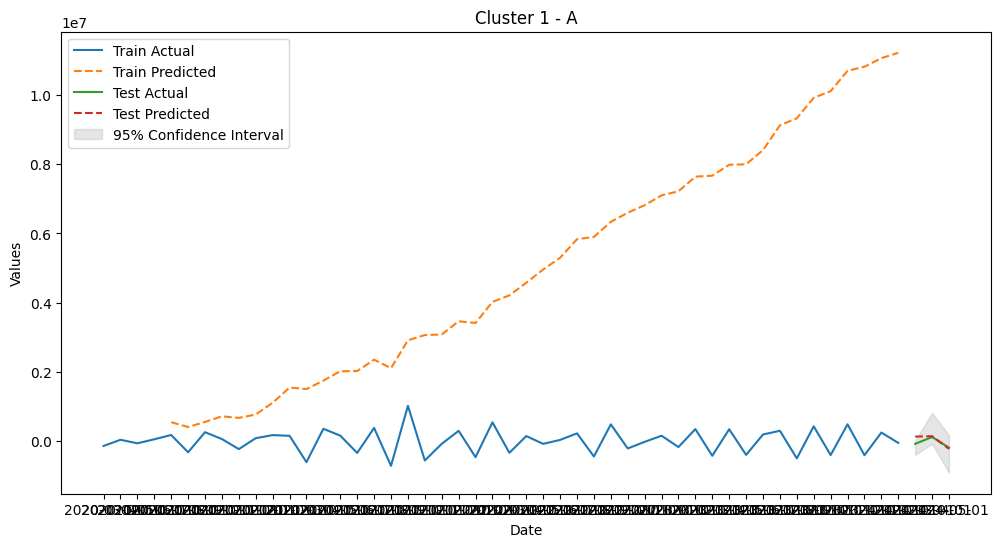

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


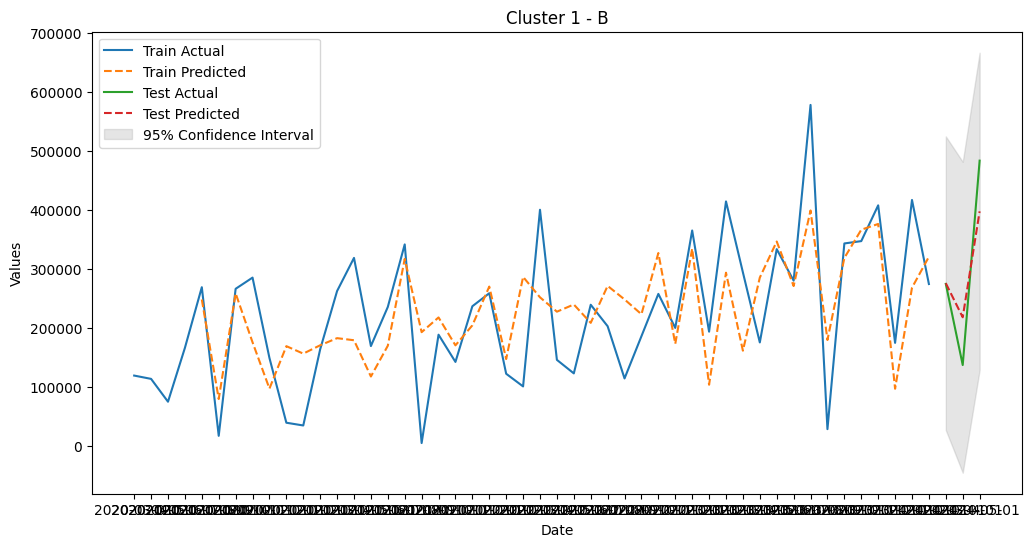

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


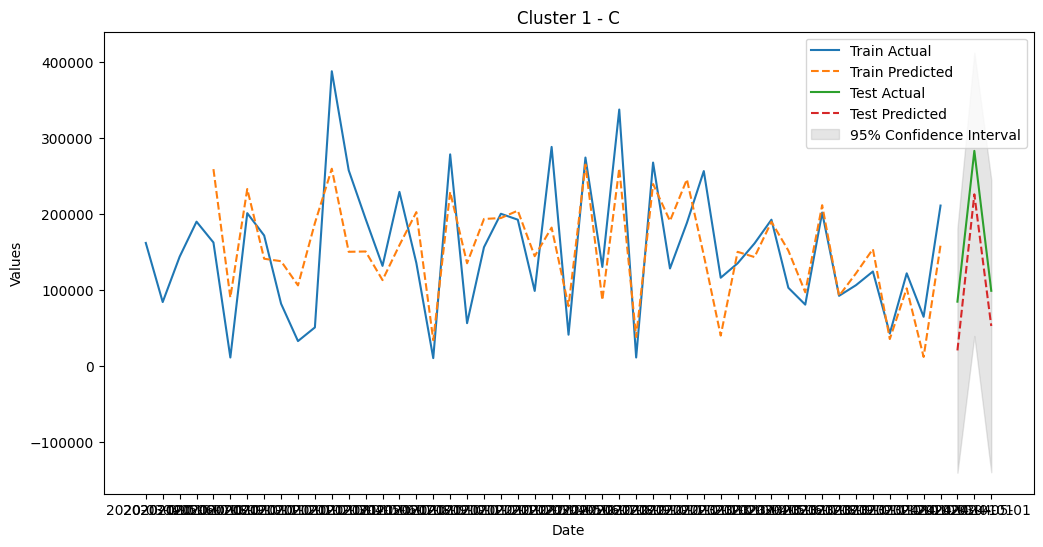

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


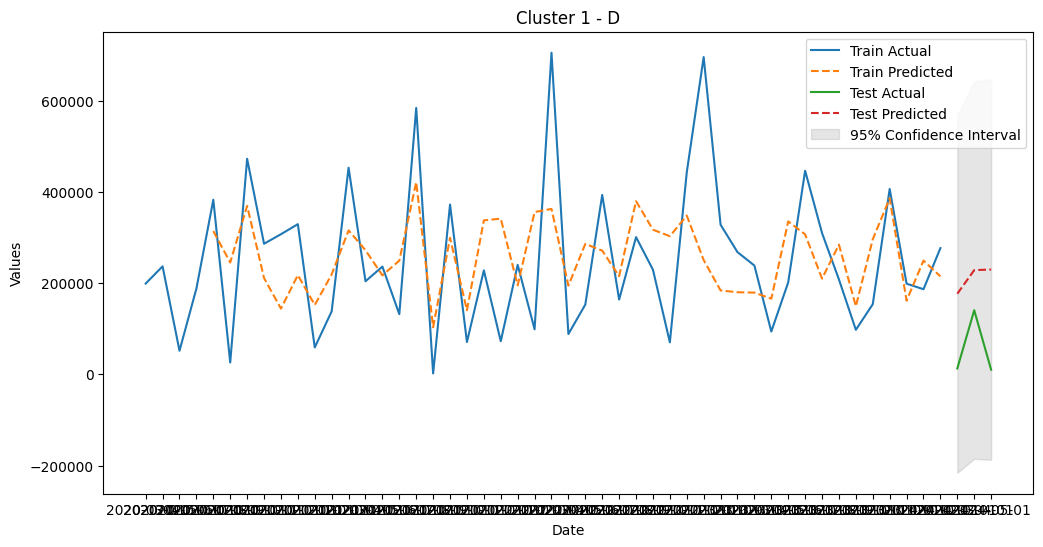

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


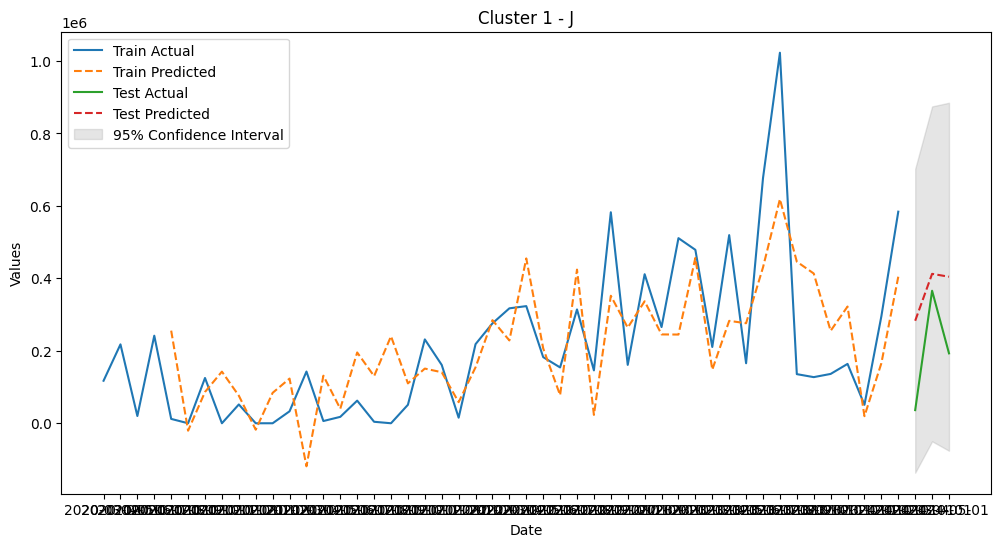

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


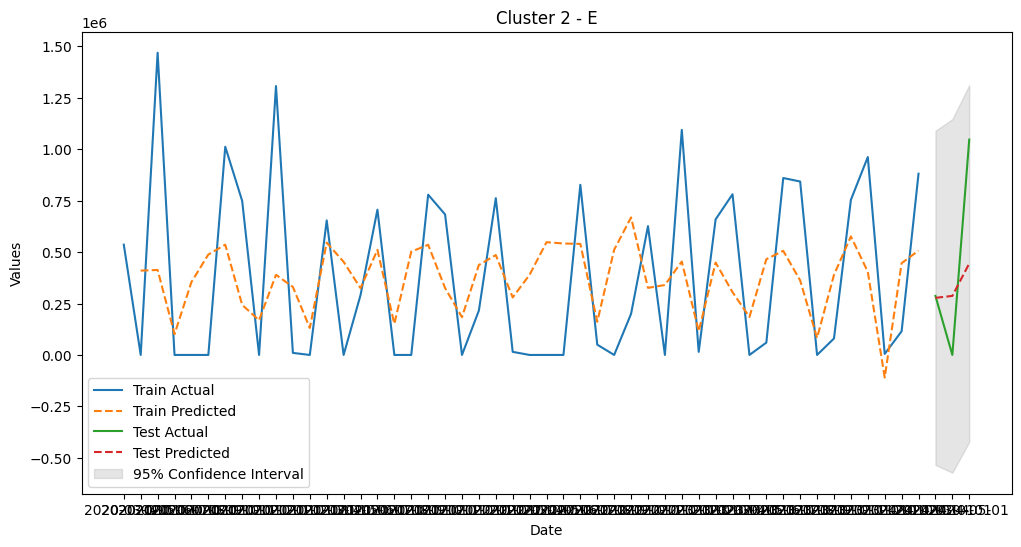

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


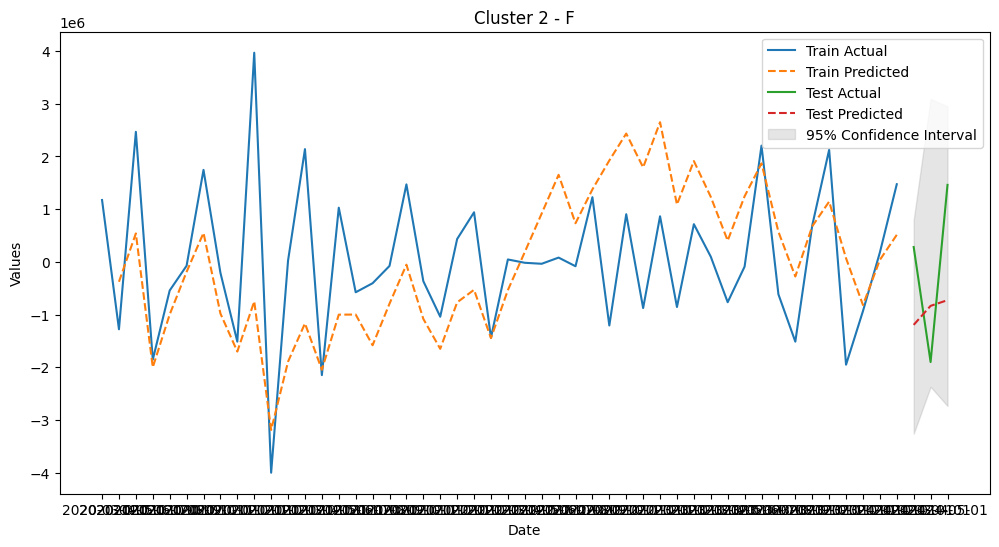

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


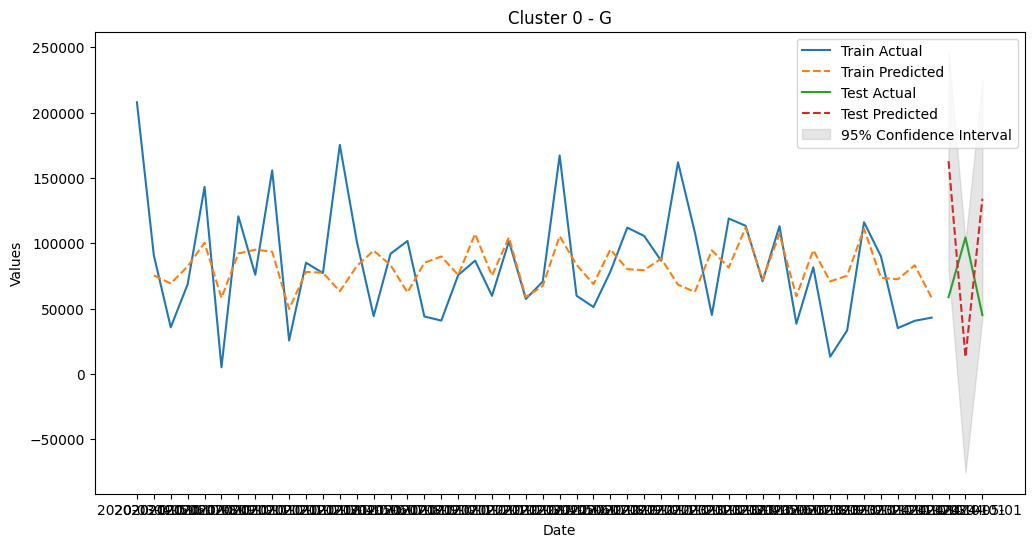

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


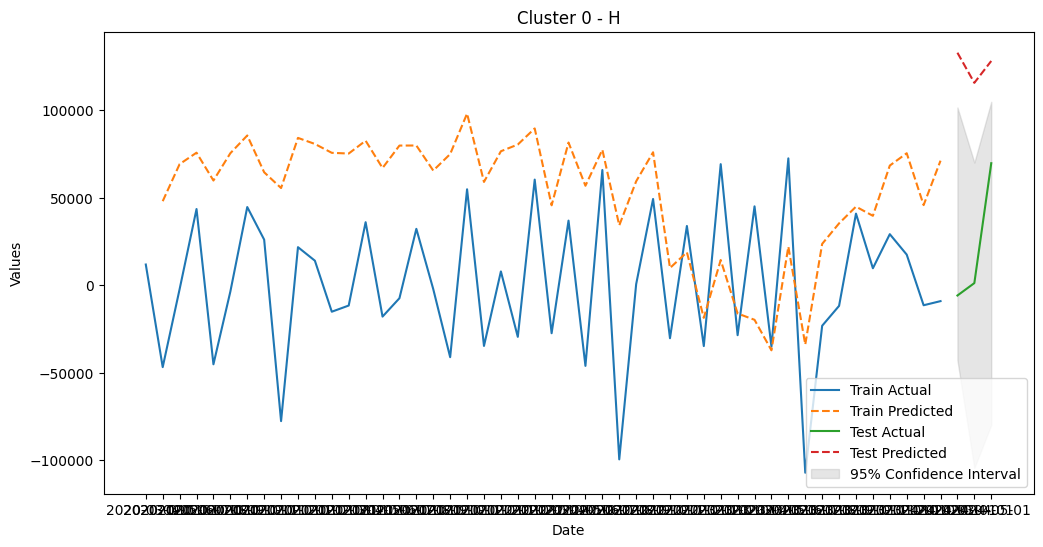

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


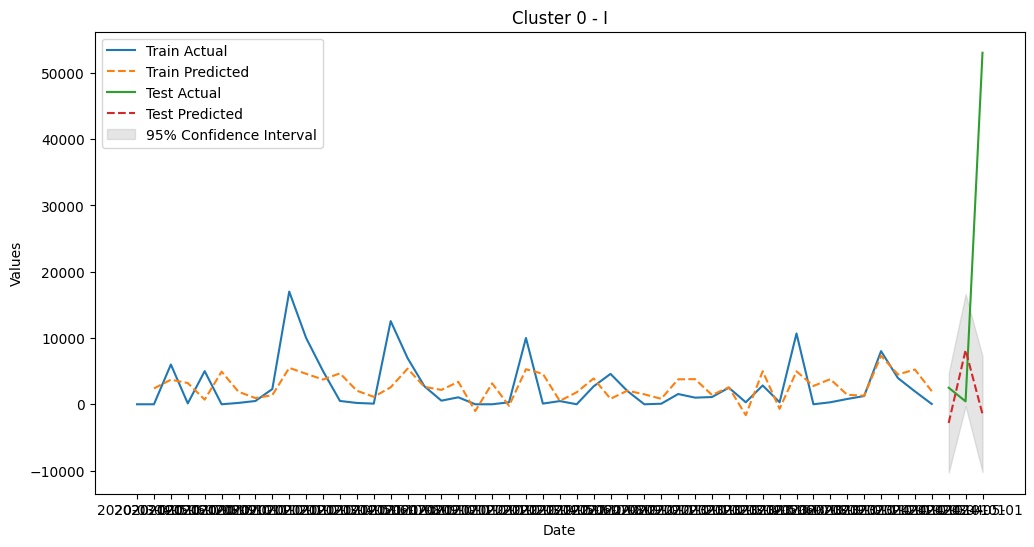

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


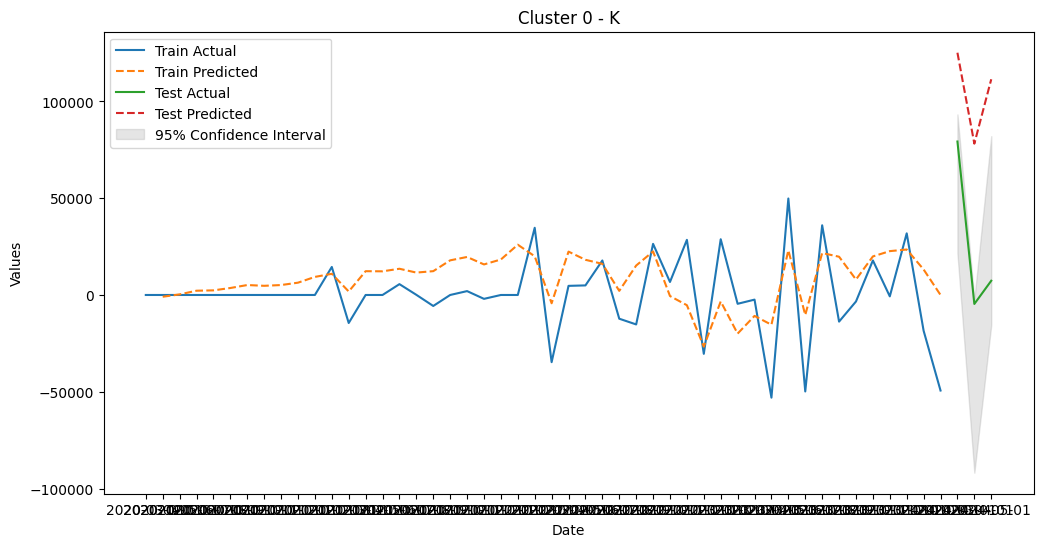

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


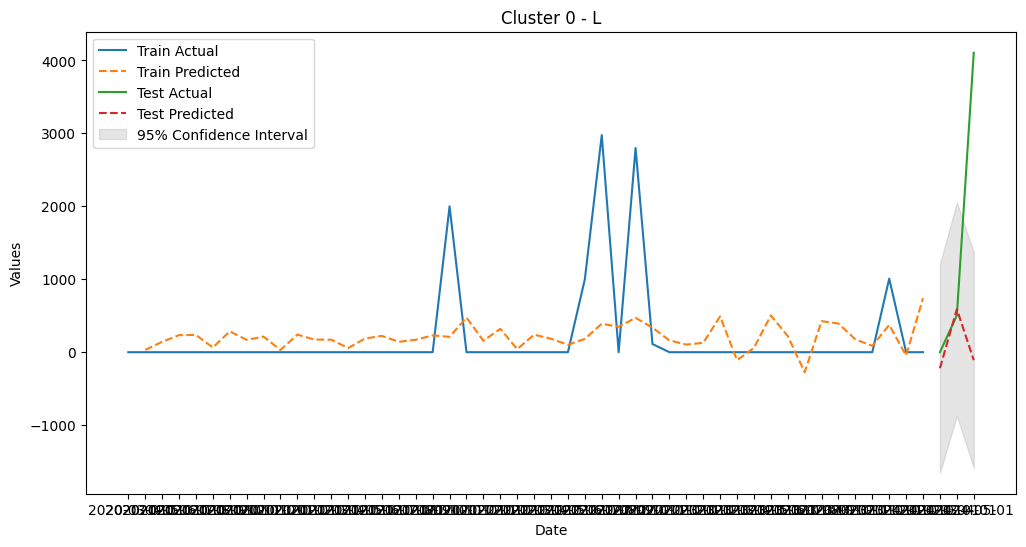

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


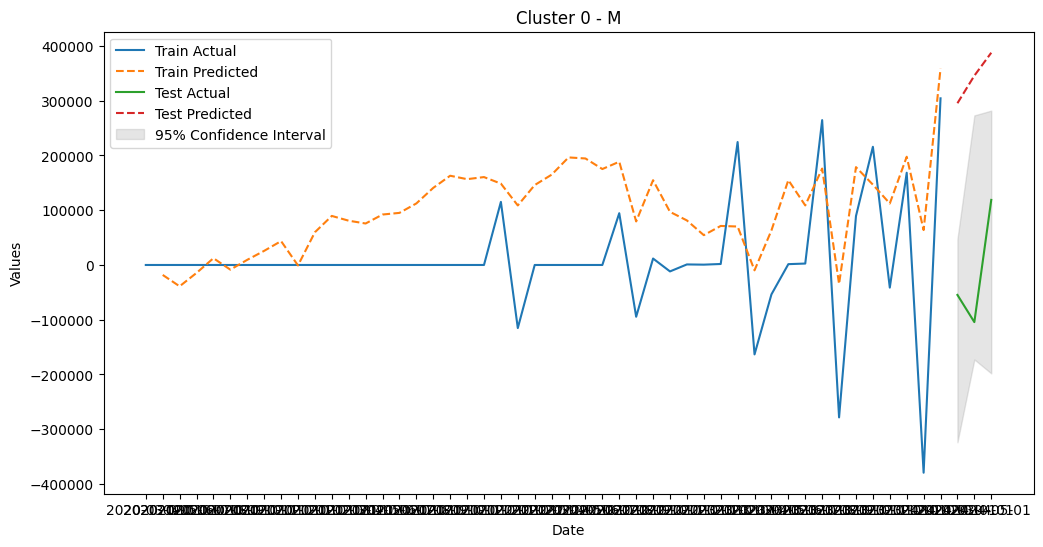

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


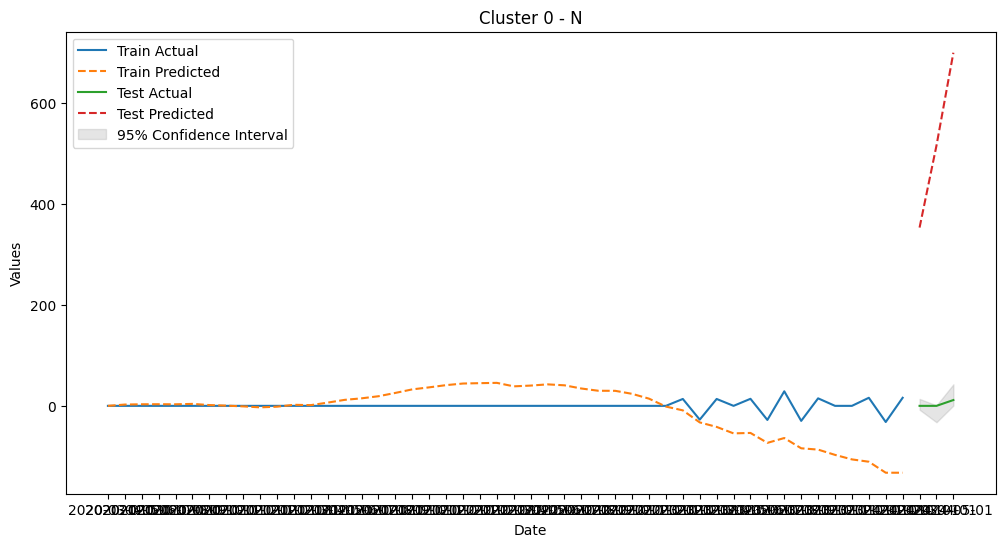

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


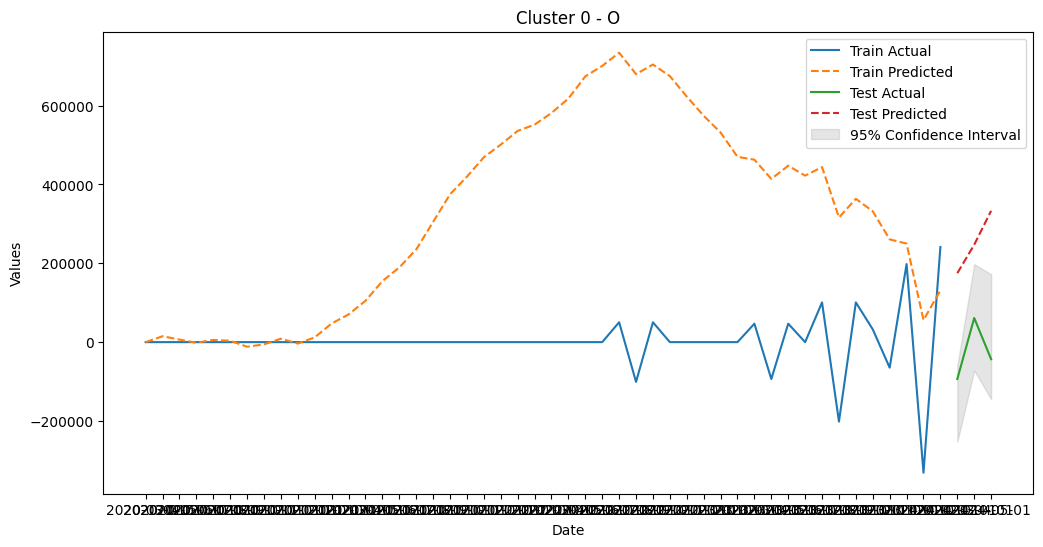

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


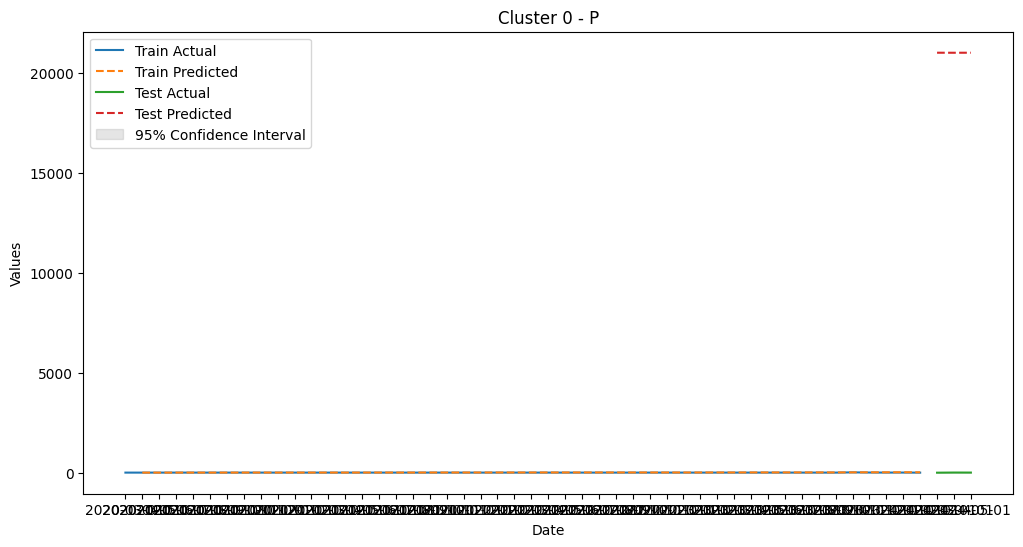

d:\WK\ydongue\AppData\Local\anaconda3\envs\devdaveyBickford\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


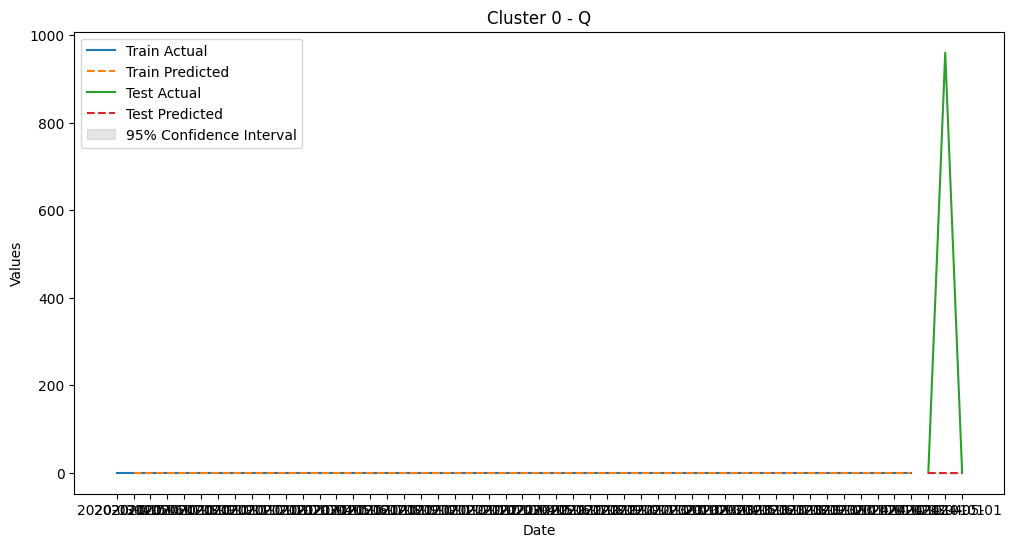

In [41]:
ordervarclust = {2: 1, 1: 4, 0: 1}    
# Boucle sur chaque cluster
for cluster in df_clust['clusters'].unique():
    families_in_cluster = df_clust[df_clust['clusters'] == cluster]['productfamilies']
    
    for family in families_in_cluster:
        # Vérifiez que la famille existe dans tous les DataFrames nécessaires
    # Sélectionner les colonnes correspondantes dans le DataFrame des séries différentiées
        cluster_data_train = df_train[families_in_cluster].dropna()
        cluster_data_test  = df_test[families_in_cluster]   
        
        
        model = VAR(cluster_data_train)
        order = ordervarclust[cluster]
        results = model.fit(order)
        
        
        forecast_horizon = len(cluster_data_test)

        # Obtenir les prévisions et les intervalles de confiance
        forecast, lower, upper = results.forecast_interval(y=cluster_data_train.values[-order:], steps=forecast_horizon, alpha=0.05)

        # Convertir en DataFrame pour faciliter la manipulation
        forecast_df = pd.DataFrame(forecast, index=cluster_data_test.index, columns=cluster_data_test.columns)
        lower_df = pd.DataFrame(lower, index=cluster_data_test.index, columns=cluster_data_test.columns)
        upper_df = pd.DataFrame(upper, index=cluster_data_test.index, columns=cluster_data_test.columns)
                 
        plt.figure(figsize=(12, 6))
        
        # Tracé des valeurs d'entraînement réelles et prédites
        plt.plot(cluster_data_train.index, cluster_data_train[family], label='Train Actual')
        plt.plot(all_predictions.index, all_predictions[family], label='Train Predicted', linestyle='--')
        
        # Tracé des valeurs de test réelles et prédites
        plt.plot(cluster_data_test.index, cluster_data_test[family], label='Test Actual')
        plt.plot(all_forecasts.index, all_forecasts[family], label='Test Predicted', linestyle='--')
        plt.fill_between(forecast_df.index, lower_df[family], upper_df[family], color='gray', alpha=0.2, label='95% Confidence Interval')

        # Titre et labels
        plt.title(f'Cluster {cluster} - {family}')
        plt.xlabel('Date')
        plt.ylabel('Values')
        plt.legend()
        plt.show()



## écrire les équations ? 
## tester d'autres modèles ?